# Desc

- using this file to practice/learn basic stats
- also want to learn standard time series analysis techniques

In [9]:
from IPython.display import display, HTML
import ipywidgets as widgets
from ipywidgets import interact
display(HTML("<style>.container { width:75% !important; }</style>"))

In [187]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [188]:
import statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.ar_model import AutoReg

from sklearn.metrics import r2_score

In [189]:

def check_stationary(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.01) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [190]:
# parameters
_round_num = 4
_time_per_day = 1000000

In [191]:
def get_file_trades(day):
    fname = f"../data/round5/trades_round_{_round_num}_day_{day}_wn.csv"
    print("fname", fname)
    return pd.read_csv(fname, sep=";")


def get_file_prices(day):
    fname = f"../data/round{_round_num}/prices_round_{_round_num}_day_{day}.csv"
    print("fname", fname)
    return pd.read_csv(fname, sep=";")

def get_symbol_prices(symbol, days):
    """ Returns DataFrame containing all price data for specified symbol, over the specified 'days'
    If symbol is None, don't filter on symbol
    """
    
    data = []
    for day in days:
        price_df = get_file_prices(day)
        data += [price_df]
    
    # concat
    price_df = pd.concat(data)
    
    # rename "bid" to "buy"
    # rename "ask" to "sell"
    price_df = price_df.rename({col: col.replace("bid", "buy") for col in price_df.columns if "bid" in col}, axis=1)
    price_df = price_df.rename({col: col.replace("ask", "sell") for col in price_df.columns if "ask" in col}, axis=1)
    price_df = price_df.rename({"timestamp": "time", "product": "symbol"}, axis=1)
    
    if symbol is not None:
        # filter for specific symbol
        price_df = price_df[price_df["symbol"] == symbol]
    
    # fix times, sort by time and reindex
    price_df["time"] = price_df["time"] + (price_df["day"] - min(days)) * _time_per_day
    price_df = price_df.sort_values(by="time").reset_index(drop=True)
    
    return price_df

def get_symbol_trades(symbol, days):
    data = []
    for day in days:
        price_df = get_file_trades(day)
        price_df["day"] = day
        data += [price_df]
    
    # concat
    price_df = pd.concat(data)
    price_df = price_df.rename({"timestamp": "time", "product": "symbol"}, axis=1)
    
    if symbol is not None:
        # filter for specific symbol
        price_df = price_df[price_df["symbol"] == symbol]
    
    # fix times, sort by time and reindex
    price_df["time"] = price_df["time"] + (price_df["day"] - min(days)) * _time_per_day
    price_df = price_df.sort_values(by="time").reset_index(drop=True)
    
    return price_df
    


def get_all_mids(days):
    price_df = get_symbol_prices(symbol=None, days=days)
    
    symbols = set(price_df["symbol"])
    
    price_df["mid"] = (price_df["buy_price_1"] + price_df["sell_price_1"]) / 2
    
    return price_df[["time", "symbol", "mid"]].copy()

In [192]:
def get_book_large_size(price_df, side):
    """ 
    side = 'buy' or 'sell' 
    
    Returns prices, sizes
    """
    
    book_range = list(range(1, 3+1))
    
    # get bids
    bid_sizes = price_df[[f"{side}_volume_{i}" for i in book_range]]
    bid_prices = price_df[[f"{side}_price_{i}" for i in book_range]]

    # replace nan with -1
    bid_sizes = bid_sizes.replace(np.nan, -1)

    # find inds
    inds = np.argmax(bid_sizes.to_numpy(), axis=1)

    # filter to keep largest bids
    bid_prices = bid_prices.to_numpy()[np.arange(len(bid_prices)), inds]
    bid_sizes = bid_sizes.to_numpy()[np.arange(len(bid_sizes)), inds]
    
    # create dataframe
    df = pd.DataFrame([bid_prices, bid_sizes]).T
    df.columns = [f"{side}_price", f"{side}_size"]
    df["time"] = price_df["time"].reset_index()["time"]
    
    return df


def get_whale_quotes(price_df):
    # get big buy/sell quotes
    buy_df = get_book_large_size(price_df, "buy")
    sell_df = get_book_large_size(price_df, "sell")

    # create big quote_df
    quote_df = pd.merge(buy_df, sell_df, on="time")
    quote_df["mid_price"] = (quote_df["buy_price"] + quote_df["sell_price"]) / 2
    quote_df["spread"] = quote_df["sell_price"] - quote_df["buy_price"]

    return quote_df

# Counterparty analysis

In [193]:
# load data
# _day_range = [-2, -1, 0]
# _day_range = [-1, -0, 1]
# _day_range = [0, 1, 2]
_day_range = [1, 2, 3]
trade_df = get_symbol_trades(None, days=_day_range)
price_df = get_symbol_prices(None, days=_day_range)
_symbols = set(trade_df["symbol"])


# compute all_mid_Df
all_dfs = []

for sym in _symbols:
    df = price_df[price_df["symbol"] == sym]
    
    datas = {
        "time": df["time"],
        "mid": df["mid_price"],
        "symbol": df["symbol"]
    }

    for i in [1, 3, 10, 30, 100, 300, 1000, 3000, 5000]:
        datas[f"d_{i}"] = -1 * df["mid_price"].diff(-1 * i)

    all_dfs += [pd.DataFrame(datas)]

all_mid_df = pd.concat(all_dfs)

# merge into trade_df
trade_df = trade_df.merge(all_mid_df, on=["symbol", "time"])
trade_df["sell_edge"] = trade_df["price"] - trade_df["mid"]

fname ../data/round5/trades_round_4_day_1_wn.csv
fname ../data/round5/trades_round_4_day_2_wn.csv
fname ../data/round5/trades_round_4_day_3_wn.csv
fname ../data/round4/prices_round_4_day_1.csv
fname ../data/round4/prices_round_4_day_2.csv
fname ../data/round4/prices_round_4_day_3.csv


In [194]:
all_mid_df['symbol'].unique()

array(['DIP', 'DIVING_GEAR', 'BERRIES', 'PICNIC_BASKET', 'COCONUTS',
       'PINA_COLADAS', 'UKULELE', 'PEARLS', 'BANANAS', 'BAGUETTE'],
      dtype=object)

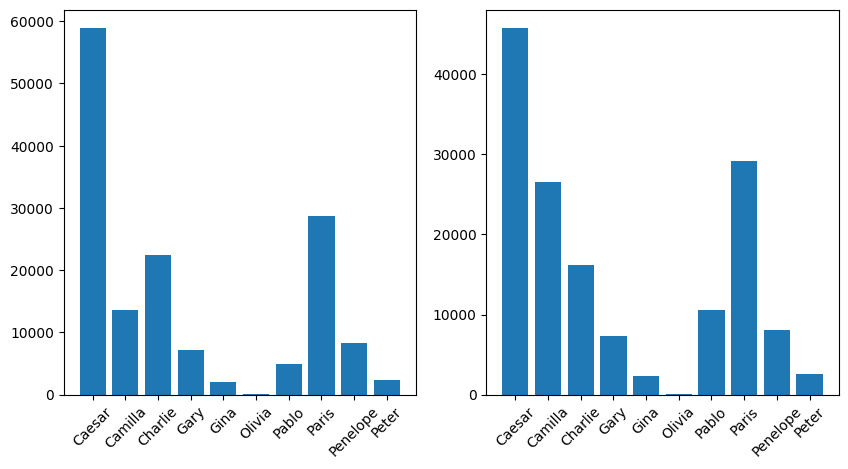

In [195]:
# general plot of data
total_buys = trade_df.groupby(["buyer"])[["quantity"]].sum()
total_sells = trade_df.groupby(["seller"])[["quantity"]].sum()

plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.bar(total_buys.index, total_buys["quantity"])
plt.xticks(rotation=45)
plt.subplot(122)
plt.bar(total_sells.index, total_sells["quantity"])
plt.xticks(rotation=45)
plt.show()

In [196]:
df1 = trade_df.groupby(["symbol", "buyer"])["quantity"].agg(["sum", "count"])
df2 = trade_df.groupby(["symbol", "seller"])["quantity"].agg(["sum", "count"])

df1 = df1.reset_index().rename({"buyer": "party", "sum": "buy_vol", "count": "buy_count"}, axis=1)
df2 = df2.reset_index().rename({"seller": "party", "sum": "sell_vol", "count": "sell_count"}, axis=1)

vol_df = df1.merge(df2, on=["symbol", "party"], how="outer")

for sym in _symbols:
    df = vol_df[vol_df["symbol"] == sym].sort_values(by="buy_vol", ascending=False)
#     df = df[(df["buy_count"] < 20)]
#     display(df.drop(["buy_count", "sell_count"], axis=1))
    display(df)

,symbol,party,buy_vol,buy_count,sell_vol,sell_count
25,DIP,Caesar,15645,2186,8217,1191
27,DIP,Paris,8403,1224,8793,1254
26,DIP,Camilla,152,26,7190,991


,symbol,party,buy_vol,buy_count,sell_vol,sell_count
28,DIVING_GEAR,Camilla,1516,788,1903,970
30,DIVING_GEAR,Paris,1444,725,1445,737
29,DIVING_GEAR,Charlie,1172,600,784,406


,symbol,party,buy_vol,buy_count,sell_vol,sell_count
12,BERRIES,Camilla,6749,739,7195,812
19,BERRIES,Penelope,2840,248,2549,223
18,BERRIES,Paris,2727,503,2382,430
14,BERRIES,Gary,2154,152,2355,165
13,BERRIES,Charlie,251,21,315,32
17,BERRIES,Pablo,175,29,83,18
20,BERRIES,Peter,146,51,170,58
15,BERRIES,Gina,90,12,83,16
16,BERRIES,Olivia,51,4,51,5


,symbol,party,buy_vol,buy_count,sell_vol,sell_count
40,PICNIC_BASKET,Camilla,2110,427,1627,293
42,PICNIC_BASKET,Penelope,1350,380,1331,387
41,PICNIC_BASKET,Pablo,1069,388,1705,588
39,PICNIC_BASKET,Caesar,934,563,800,490


,symbol,party,buy_vol,buy_count,sell_vol,sell_count
21,COCONUTS,Caesar,18330,463,18928,473
22,COCONUTS,Charlie,4924,324,1230,162
24,COCONUTS,Peter,1592,210,1705,221
23,COCONUTS,Pablo,776,45,3759,186


,symbol,party,buy_vol,buy_count,sell_vol,sell_count
43,PINA_COLADAS,Caesar,5830,360,5307,302
44,PINA_COLADAS,Charlie,1437,229,408,112
46,PINA_COLADAS,Peter,631,177,712,208
45,PINA_COLADAS,Pablo,318,34,1789,178


,symbol,party,buy_vol,buy_count,sell_vol,sell_count
47,UKULELE,Caesar,5966,1609,4204,1407
50,UKULELE,Paris,4207,1408,4021,1326
48,UKULELE,Camilla,14,6,1962,290
49,UKULELE,Olivia,9,3,9,3


,symbol,party,buy_vol,buy_count,sell_vol,sell_count
33,PEARLS,Charlie,4426,1773,4400,1728
37,PEARLS,Paris,2598,2229,2526,2197
36,PEARLS,Pablo,1643,648,1781,688
32,PEARLS,Camilla,1587,742,1450,689
34,PEARLS,Gary,1529,290,1433,280
38,PEARLS,Penelope,1522,503,1599,549
31,PEARLS,Caesar,1219,859,1303,907
35,PEARLS,Gina,544,131,576,137


,symbol,party,buy_vol,buy_count,sell_vol,sell_count
5,BANANAS,Charlie,10176,3047,9065,2510
6,BANANAS,Gary,3515,304,3536,316
10,BANANAS,Paris,3137,2687,3485,3100
11,BANANAS,Penelope,2648,467,2560,497
4,BANANAS,Camilla,1491,735,1500,765
7,BANANAS,Gina,1443,217,1677,277
9,BANANAS,Pablo,911,389,1432,561
3,BANANAS,Caesar,795,634,861,452
8,BANANAS,Olivia,51,4,51,6


,symbol,party,buy_vol,buy_count,sell_vol,sell_count
0,BAGUETTE,Caesar,10205,1720,6187,1140
2,BAGUETTE,Paris,6226,1147,6589,1193
1,BAGUETTE,Camilla,33,6,3688,540


In [197]:
party = "Giulia"

party_trades = trade_df[(trade_df["buyer"] == party) | (trade_df["seller"] == party)]

syms = set(party_trades["symbol"])

for sym in syms:
    plt.figure(figsize=(13, 5))
    df = price_df[price_df["symbol"] == sym].reset_index()
    
    tdf = party_trades[party_trades["symbol"] == sym]
    

    for index, row in tdf.iterrows():
        is_buy = row["buyer"] == party
#         if not is_buy:
#             continue
        color = "green" if is_buy else "red"
        time = row["time"] // 100
        plt.axvline(x=time, color=color)
    
    plt.plot(df["mid_price"])

    plt.title(sym)
    plt.show()

## Analysis per symbol per trader

In [209]:
trade_df['symbol'].unique()

array(['PEARLS', 'BANANAS', 'DIP', 'UKULELE', 'BAGUETTE', 'DIVING_GEAR',
       'PINA_COLADAS', 'COCONUTS', 'PICNIC_BASKET', 'BERRIES'],
      dtype=object)

In [217]:
#SYMBOL TO USE FOR NEXT FOUR CELLS
symbol = "BAGUETTE"

# CELL INFO
# For this symbol, this cell gets data on trades for each trader
#'time' - timestep 
#'position' - position 
#'money' - money 
#'n_buy' - number of total buy trades 
#'n_sell' - number of total sell trades 
#'n_trade' - number of total trades 
#'is_buy' - whether it was a buy (true if buy)

trade_df = trade_df.sort_values(by='time')
trade_df_symbol = trade_df[(trade_df['symbol'] == symbol) | (trade_df['symbol'] == symbol)] 
names_list = pd.concat([trade_df['buyer'], trade_df['seller']]).unique()


position_df_dict = {name : pd.DataFrame(columns=['time', 'position', 'money', 'n_buy', 'n_sell', 'n_trade', 'is_buy']) for name in names_list}
position_dict = {name : 0 for name in names_list}
money_dict = {name : 0 for name in names_list}
buy_count_dict = {name : 0 for name in names_list}
sell_count_dict = {name : 0 for name in names_list}

for index, row in trade_df_symbol.iterrows():
    buyer = row['buyer']
    seller = row['seller']
    price = row['price']
    quantity = row['quantity']
    time = row['time']
    
    #update buyer position
    position_dict[buyer] += quantity
    money_dict[buyer] -= (quantity * price)
    buy_count_dict[buyer] += 1
    new_row = {'time': time, 
               'position': position_dict[buyer], 
               'money': money_dict[buyer],
               'n_buy': buy_count_dict[buyer],
               'n_sell': sell_count_dict[buyer],
               'n_trade': buy_count_dict[buyer]+sell_count_dict[buyer],
               'is_buy': True,
              }
    position_df_dict[buyer].loc[len(position_df_dict[buyer])] = new_row
    
    #update seller position
    position_dict[seller] -= quantity
    money_dict[seller] += (quantity * price)
    sell_count_dict[seller] += 1
    new_row = {'time': time, 
               'position': position_dict[seller], 
               'money': money_dict[seller],
               'n_buy': buy_count_dict[seller],
               'n_sell': sell_count_dict[seller],
               'n_trade': buy_count_dict[seller]+sell_count_dict[seller],
               'is_buy': False,
              }
    
    position_df_dict[seller].loc[len(position_df_dict[seller])] = new_row
    

In [218]:
# CELL INFO
# Get final prices for each of the symbols
symbol_list = all_mid_df['symbol'].unique()
all_mid_df_group_symbol = all_mid_df.groupby(["symbol"])


final_price_dict = {}

for sym in symbol_list:
    all_mid_df_sym = all_mid_df_group_symbol.get_group(sym)
    last_mid_price = all_mid_df_sym['mid'].iloc[-1]
    final_price_dict[sym] = last_mid_price
    
#get final price for symbol we are looking at
final_price_sym = final_price_dict[symbol]

In [219]:
#CELL INFO
#get final PnL for each trader for the symbol
final_pnl_dict = {}
for name in position_df_dict:
    #check if made no trades
    if len(position_df_dict[name]) == 0:
        final_pnl_dict[name] = 0
    else:
        final_money = position_df_dict[name]['money'].iloc[-1]
        final_position = position_df_dict[name]['position'].iloc[-1]
        final_pnl_dict[name] = final_money + final_position * final_price_sym

{'Paris': -111312.0,
 'Charlie': 0,
 'Caesar': 500464.0,
 'Penelope': 0,
 'Camilla': -389152.0,
 'Pablo': 0,
 'Gina': 0,
 'Gary': 0,
 'Peter': 0,
 'Olivia': 0}

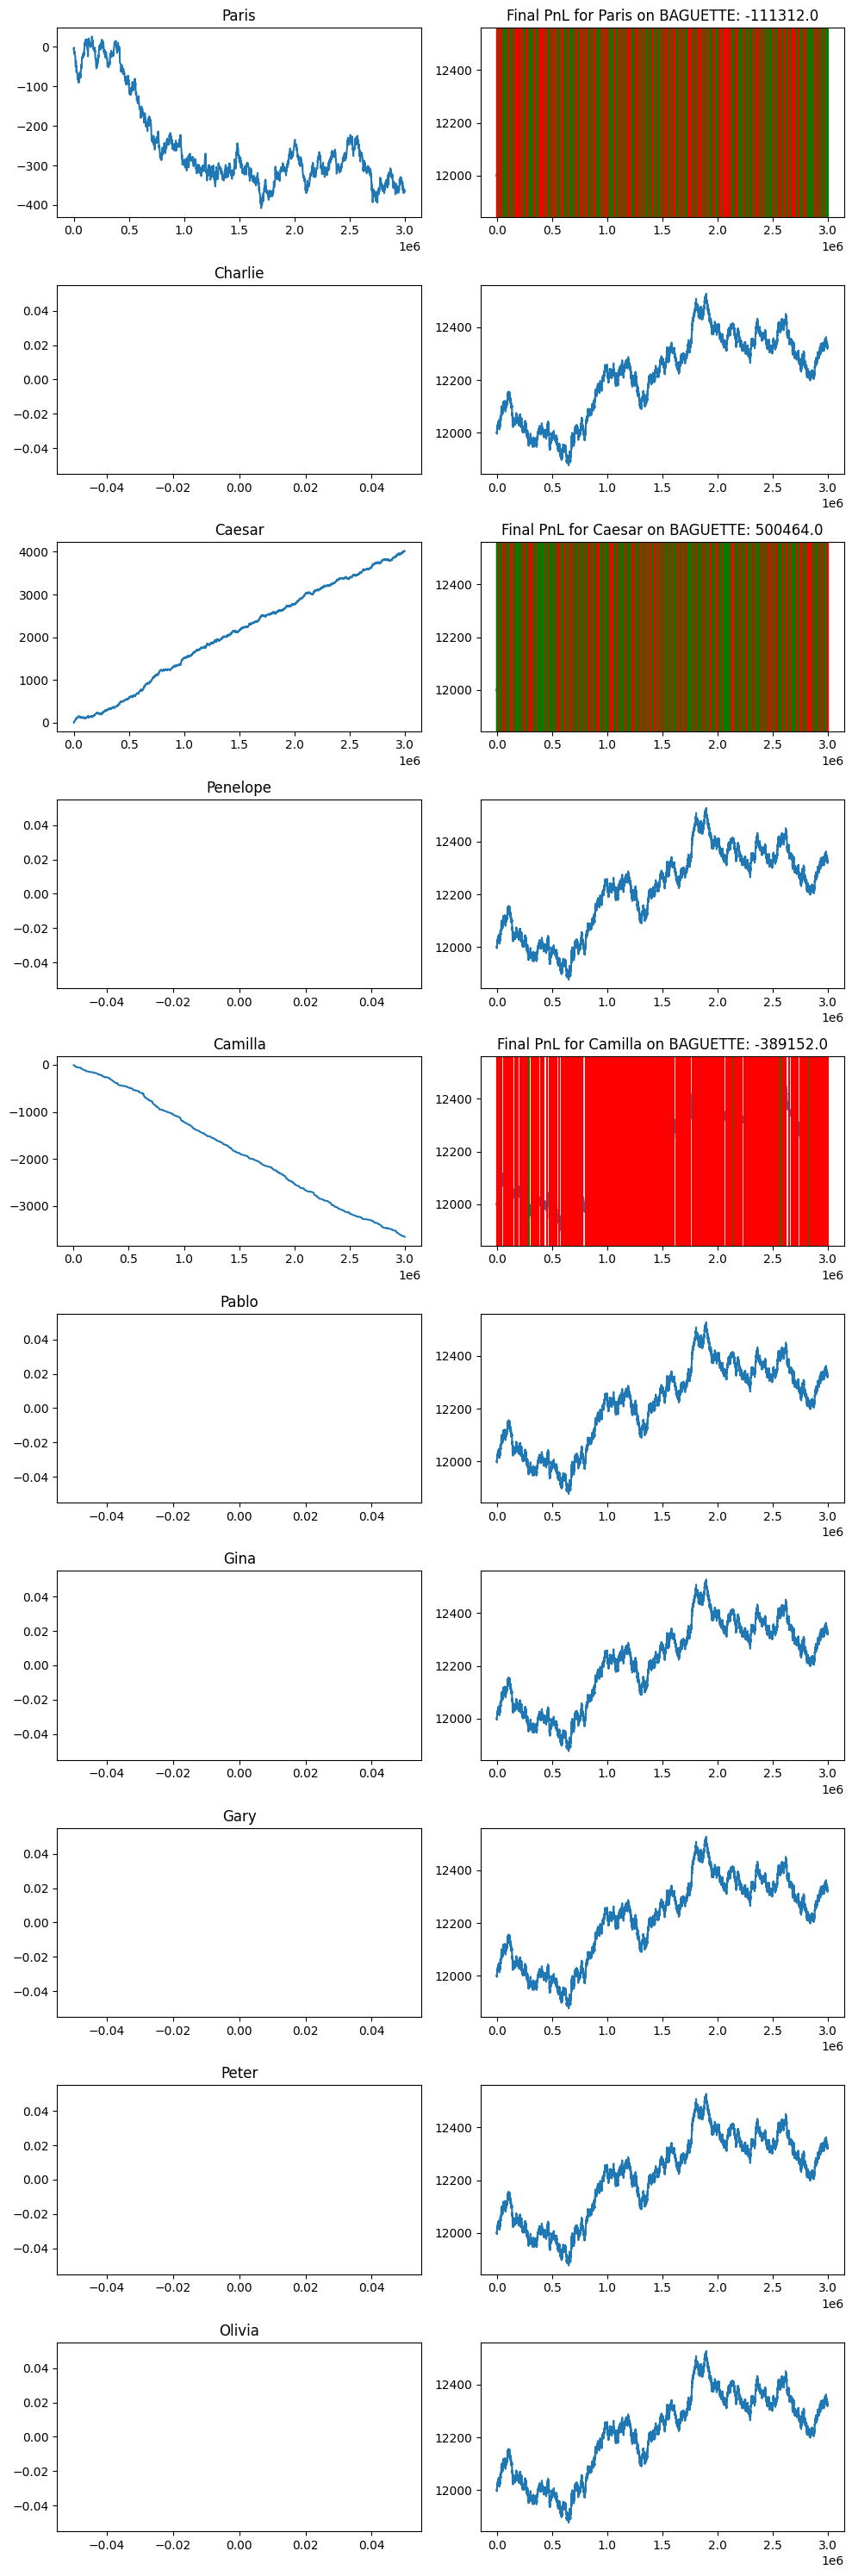

In [220]:
#CELL INFO
#plot positions for each trader
symbol_price_df = all_mid_df_group_symbol.get_group(symbol)



time_range = (0, float('inf'))
#filter by time
symbol_price_df = symbol_price_df[(time_range[0] <= symbol_price_df['time']) & (symbol_price_df['time'] <= time_range[1])]


fig, axs = plt.subplots(len(position_df_dict), 2, figsize=(10, 3*len(position_df_dict)))

for i, (name, df) in enumerate(position_df_dict.items()):
    #filter by time
    df = df[(time_range[0] <= df['time']) & (df['time'] <= time_range[1])]

    
    # plot the time vs. position
    axs[i][0].plot(df['time'], df['position'])
    axs[i][0].set_title(name)
    
    
    #plot the symbol price data and vertical lines where the trader bought/sold
    axs[i][1].plot(symbol_price_df['time'], symbol_price_df['mid'])
    # loop through the rows of df
    if len(df) == 0:
        continue
    for index, row in df.iterrows():
        # check if is_buy is True
        if row['is_buy']:
            # plot a green vertical line at the time value where buy
            axs[i][1].axvline(x=row['time'], color='green')
        else:
            # plot a red vertical line at the time value where sell
            axs[i][1].axvline(x=row['time'], color='red')  
    
    axs[i][1].set_title(f'Final PnL for {name} on {symbol}: {final_pnl_dict[name]}')

plt.tight_layout()
plt.show()

# General Analysis Strategy
- find who is making the most money
- find their most profitable types of trades
    - filter by symbols + buy/sell side
    - map their return after 1, 3, 10, 30, ... turns

In [156]:
cols = ["count", "sell_edge"] + [col for col in trade_df.columns if col.startswith("d_")]
sort_by = "d_100"

# in buyers, most positive is best
counts = trade_df.groupby(["buyer", "symbol"])["time"].count()
buys = trade_df.groupby(["buyer", "symbol"]).mean()
buys["count"] = counts
display(buys[cols].sort_values(by=sort_by, ascending=False))
# display(buys[cols])

# in sellers, most negative is best
counts = trade_df.groupby(["seller", "symbol"])["time"].count()
sells = trade_df.groupby(["seller", "symbol"]).mean()
sells["count"] = counts
display(sells[cols].sort_values(by=sort_by, ascending=True))


/var/folders/sv/mwd8vjhd6dn5tb688gtzykf00000gn/T/ipykernel_12411/4203186648.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  buys = trade_df.groupby(["buyer", "symbol"]).mean()


count  sell_edge       d_1       d_3      d_10  \
buyer    symbol                                                         
Olga     BANANAS           1   0.500000  3.500000  4.000000  7.000000   
Olivia   BANANAS           3   3.333333  0.500000 -0.666667  1.166667   
Charlie  PEARLS         1764  -0.854592  2.149093  2.129819  2.145125   
Peter    PINA_COLADAS    178   1.351124  0.235955  0.002809  0.522472   
Pablo    PINA_COLADAS     52  -0.211538 -0.798077 -1.269231 -0.365385   
Caesar   PINA_COLADAS    381  -0.439633  0.422572  0.391076  0.652632   
         COCONUTS        480  -0.198958  0.700000  0.793750  0.775000   
Charlie  BANANAS        3021  -1.871069  1.001986  1.043874  1.043406   
Peter    COCONUTS        226   1.269912 -0.035398 -0.112832 -0.139381   
Caesar   PEARLS          935  -3.330481  0.287166  0.357219  0.402034   
Charlie  PINA_COLADAS    243  -1.446502 -0.076132  0.016461 -0.152263   
Pablo    COCONUTS         49  -0.295918 -0.612245 -0.591837 -0.704082   
Caesar   BANANAS         650  -2.304615  0.336923  0.276923  0.319231   
Gary     PEARLS          317   3.340694 -0.197161 -0.238170 -0.296530   
Penelope PEARLS          478   3.333682 -0.166318 -0.218619 -0.148536   
Gary     BANANAS         282   2.599291  0.187943  0.186170 -0.033688   
Charlie  COCONUTS        323  -1.320433  0.133127  0.094427 -0.105263   
Camilla  BANANAS         719  -2.760083 -0.002782 -0.021558 -0.112273   
Penelope BANANAS         468   2.553419  0.106838  0.017094 -0.118590   
Camilla  PEARLS          754  -2.554377 -0.765915 -0.602122 -0.604111   
Paris    PEARLS         2241   1.691432 -0.844712 -0.870370 -0.859152   
         BANANAS        2756   1.197206 -0.925254 -0.917271 -0.912672   
Pablo    BANANAS         436  -0.393349 -1.346330 -1.477064 -1.480505   
         PEARLS          658  -0.098784 -2.138298 -2.099544 -2.017477   
Gina     BANANAS         263  -1.359316 -2.249049 -2.355513 -2.425856   
         PEARLS          137  -1.452555 -2.682482 -2.985401 -2.894161   

                           d_30      d_100      d_300     d_1000     d_3000  \
buyer    symbol                                                               
Olga     BANANAS       8.000000  16.000000  18.500000   5.500000  -5.000000   
Olivia   BANANAS       1.666667   2.833333   5.000000  12.500000 -10.500000   
Charlie  PEARLS        2.151644   2.170545   2.112543   2.132413   2.173927   
Peter    PINA_COLADAS  0.306180   2.016854  -0.363636  -1.250000  -1.895833   
Pablo    PINA_COLADAS  1.086538   1.653846  -4.528846  -9.872549  -2.270833   
Caesar   PINA_COLADAS  0.200000   1.417772  -1.629679  -1.703857  -9.069069   
         COCONUTS      0.591667   0.714885   1.338983   1.292842  -1.215618   
Charlie  BANANAS       0.987740   0.610262  -0.237336  -3.383390 -13.484698   
Peter    COCONUTS      0.101770   0.417778  -0.439732   0.607306  -6.731343   
Caesar   PEARLS        0.346895   0.355996   0.363095   0.437707   0.356465   
Charlie  PINA_COLADAS  0.178423   0.329876  -0.369295  -3.320513  -2.829384   
Pablo    COCONUTS     -0.602041   0.326531   0.132653  -3.336735 -11.344444   
Caesar   BANANAS       0.318462   0.124615  -0.788162  -3.521395 -13.687175   
Gary     PEARLS       -0.302839  -0.140379  -0.395899  -0.204473  -0.143581   
Penelope PEARLS       -0.278243  -0.191824  -0.213836  -0.200637  -0.203917   
Gary     BANANAS       0.200355  -0.193262  -1.562278  -3.897059 -15.010000   
Charlie  COCONUTS      0.007740  -0.295666  -1.490625  -0.390675  -0.836806   
Camilla  BANANAS      -0.117852  -0.368017  -1.417135  -4.728183 -13.972435   
Penelope BANANAS      -0.059829  -0.491453  -1.502141  -4.327815 -14.474515   
Camilla  PEARLS       -0.654509  -0.492042  -0.482620  -0.511644  -0.523392   
Paris    PEARLS       -0.807641  -0.820421  -0.890266  -0.760148  -0.864293   
         BANANAS      -1.060320  -1.325455  -2.154832  -5.679309 -15.333199   
Pablo    BANANAS      -1.485092  -1.555046  -2.672454  -6.141509 -16.442928   
   

/var/folders/sv/mwd8vjhd6dn5tb688gtzykf00000gn/T/ipykernel_12411/4203186648.py:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sells = trade_df.groupby(["seller", "symbol"]).mean()


count  sell_edge       d_1       d_3      d_10  \
seller   symbol                                                         
Olivia   BANANAS           4  -3.500000 -0.500000 -0.500000 -1.250000   
Charlie  PEARLS         1731   0.798094 -2.231658 -2.240901 -2.193819   
         BANANAS        2630   0.900760 -1.493346 -1.531559 -1.557246   
Peter    PINA_COLADAS    211  -1.296209 -0.061611 -0.165877 -0.315166   
Penelope BANANAS         498  -2.601406 -0.102410 -0.090361 -0.109438   
Caesar   PEARLS          902   3.347007 -0.374169 -0.414634 -0.425166   
Pablo    COCONUTS        204  -1.232843  0.053922  0.068627  0.024510   
Gary     PEARLS          299  -3.463211 -0.197324 -0.018395 -0.195652   
Paris    BANANAS        3108  -2.428732  0.331885  0.332797  0.312138   
Peter    COCONUTS        205  -1.251220  0.160976  0.136585  0.004878   
Caesar   BANANAS         455   2.006593  0.600000  0.592308  0.607930   
Gary     BANANAS         310  -2.740323 -0.017742 -0.064516  0.029032   
Camilla  BANANAS         769   2.213914  0.518205  0.517555  0.476562   
Penelope PEARLS          621  -3.413849  0.099034  0.065217  0.180645   
Camilla  PEARLS          700   2.529286  0.542857  0.457857  0.442060   
Charlie  PINA_COLADAS    121   1.471074  0.198347 -0.020661  0.194215   
Caesar   COCONUTS        490   0.029592  0.647959  0.723469  0.656122   
Charlie  COCONUTS        179   1.363128 -0.114525 -0.220670 -0.310056   
Paris    PEARLS         2200  -1.682727  0.772273  0.777955  0.812045   
Pablo    PINA_COLADAS    208  -1.153846  0.036058  0.341346  0.528846   
         BANANAS         532   0.097744  1.985902  2.094925  2.108491   
         PEARLS          693   0.168110  2.118326  2.176046  2.175325   
Caesar   PINA_COLADAS    314   0.146497  0.396497  0.171975  0.696486   
Gina     BANANAS         293   0.836177  2.901024  2.959044  2.866894   
         PEARLS          138   1.460145  2.344203  2.855072  3.007246   

                           d_30     d_100      d_300     d_1000     d_3000  \
seller   symbol                                                              
Olivia   BANANAS      -3.625000 -9.000000 -12.125000 -23.750000 -42.500000   
Charlie  PEARLS       -2.232813 -2.180290  -2.299942  -2.153110  -2.251933   
         BANANAS      -1.674087 -1.921173  -2.791108  -6.092549 -16.268954   
Peter    PINA_COLADAS  0.433333 -0.727273  -1.394737  -5.129353  -3.141711   
Penelope BANANAS      -0.242972 -0.495976  -1.432790  -5.548755 -15.300218   
Caesar   PEARLS       -0.362778 -0.352058  -0.484916  -0.416195  -0.416972   
Pablo    COCONUTS     -0.215686 -0.220588  -2.284653  -1.625000  -0.874332   
Gary     PEARLS       -0.187291 -0.140468  -0.178451  -0.011986  -0.069597   
Paris    BANANAS       0.229395 -0.120045  -1.002435  -4.073324 -13.961912   
Peter    COCONUTS      0.482927  0.000000   0.086634   0.459184  -3.474576   
Caesar   BANANAS       0.600442  0.044150  -0.565410  -3.467816 -13.613184   
Gary     BANANAS       0.256452  0.122977  -0.646865  -3.682274 -12.832734   
Camilla  BANANAS       0.440104  0.203125  -0.829188  -4.311995 -13.621212   
Penelope PEARLS        0.208065  0.267367   0.031863   0.160299   0.127434   
Camilla  PEARLS        0.549356  0.467765   0.476327   0.528024   0.510285   
Charlie  PINA_COLADAS -0.421488  0.578512  -0.566667   0.176471   2.935345   
Caesar   COCONUTS      0.461224  0.593429   1.266529   0.943277  -2.022831   
Charlie  COCONUTS     -0.005587  0.626404  -0.598870   1.299419  -5.972050   
Paris    PEARLS        0.791364  0.823409   0.844108   0.844000   0.834258   
Pablo    PINA_COLADAS  0.541063  1.263285  -0.446602  -3.505025  -6.965714   
         BANANAS       2.138679  2.026565   1.242308  -1.948617 -10.809979   
         PEARLS        2.080808  2.194364   2.196637   2.134731   2.104065   
Caesar   PINA_COLADAS  0.249201  2.827974  -1.774351  -1.349835  -9.143617   
Gina     BANANAS       3.049488  2.945392   1.448097  -1.388502 -12.342593   
         PEARLS        

## Pairs trading

In [21]:
_day_range = [1, 2, 3]
# _day_range = [-1, 0, 1]

coco_price_df = get_symbol_prices("COCONUTS", _day_range)
pina_price_df = get_symbol_prices("PINA_COLADAS", _day_range)

coco_df = get_whale_quotes(coco_price_df)
pina_df = get_whale_quotes(pina_price_df)
pair_df = pd.DataFrame({
    "mid_coco": coco_df["mid_price"], 
    "mid_pina": pina_df["mid_price"],
    "time": pina_df["time"],
})

fig, ax = plt.subplots()

ax.plot(pair_df["time"], pair_df["mid_coco"], color="blue", label="coco")
ax.legend(loc=1)

ax2 = ax.twinx()

ax2.plot(pair_df["time"], pair_df["mid_pina"], color="orange", label="pina")
ax2.legend(loc=2)

fname ../data/round2/prices_round_2_day_1.csv
fname ../data/round2/prices_round_2_day_2.csv


FileNotFoundError: [Errno 2] No such file or directory: '../data/round2/prices_round_2_day_2.csv'

### plot first diffs over time

In [ ]:
plt.scatter(pair_df["mid_coco"].diff(1), pair_df["mid_pina"].diff(1))

In [ ]:
plt.figure(figsize=(12, 3))

all_x = pair_df["mid_coco"].diff(1).dropna()
all_y = pair_df["mid_pina"].diff(1).dropna()

xlim = all_x.min(), all_x.max()
ylim = all_y.min(), all_y.max()

big_model = np.poly1d(np.polyfit(all_x, all_y, deg=1))
print("big_model", big_model.coef)

### params
chunk_size = 100


model_data = []

for i in range(len(pair_df) - chunk_size):

    lb = i
    ub = lb + chunk_size

    df = pair_df.iloc[lb:ub]

    x = df["mid_coco"].diff(1).dropna()
    y = df["mid_pina"].diff(1).dropna()

    inds = x.index.intersection(y.index)

    x = x[inds]
    y = y[inds]

    # fit line
    model = np.poly1d(np.polyfit(x, y, deg=1))
    model_data += [{
        "m": model.coef[0],
        "b": model.coef[1],
        "r2": r2_score(y, model(x)),
    }]

#     if i < 5:
#         plt.subplot(121)
#         plt.hist(x, bins=50)
#         plt.hist(y, bins=50, alpha=0.5)

#         plt.subplot(122)
#         plt.scatter(x, y, s=1)
#         plt.plot(x, model(x), color="red", label="fit")
#         plt.plot(x, model(x), color="black", label="fit")
#         plt.xlim(xlim)
#         plt.ylim(ylim)
        
#         plt.show()

#         print("model", model.coef)
model_df = pd.DataFrame(model_data)

In [ ]:
plt.plot(model_df["r2"], label="r2")
plt.plot(model_df["m"], label="m")
plt.plot(model_df["b"], label="b")
plt.axhline(y=1.5)

plt.legend()


In [ ]:
check_stationary(model_df["m"])

In [ ]:
# get errors
error = pair_df["mid_pina"] - pair_df["mid_coco"] * 1.5 - 3000
error_df = pd.DataFrame({"error": error})

# check stationarity of the error
check_stationary(error_df["error"])

# get `change` stats
error_df["above"] = error_df["error"] > 0
error_df["change"] = error_df["above"] != error_df["above"].shift(1)


In [ ]:
plt.plot(error_df["error"])

In [ ]:
error.describe()

In [ ]:
low, high = 0, 0

bounds = []

for index, row in error_df.iterrows():
    if row["change"]:
        bounds += [(low, high)]
        low, high = 0, 0
        
    # record max error
    low = min(low, row["error"])
    high = max(low, row["error"])
    
    
df = pd.DataFrame(bounds, columns=["low", "high"])
df["bound"] = np.maximum(df["low"].abs(), df["high"].abs())

# get number of times we reach each threshold
freq_df = df.groupby("bound")[["low"]].count().rename({"low": "count"}, axis=1)
freq_df = freq_df.sort_index(ascending=False).cumsum().reset_index()
freq_df["pnl"] = freq_df["bound"] * freq_df["count"]

In [ ]:
plt.plot(freq_df["bound"], freq_df["pnl"])

In [ ]:
freq_df.sort_values(by="pnl", ascending=False).iloc[:20]

## round 4

In [ ]:
del pair_df

In [ ]:
_day_range = [1, 2, 3]

raw_df = get_symbol_prices(None, _day_range)

syms = ["DIP", "BAGUETTE", "UKULELE", "PICNIC_BASKET"]

all_dfs = {}
for sym in syms:
    df = raw_df[raw_df["symbol"] == sym]
    df = get_whale_quotes(df)
    all_dfs[sym[:3].lower()] = df["mid_price"]
#     all_dfs["time"] = df["time"]
    

price_df = pd.DataFrame(all_dfs)

In [ ]:
price_df["agg"] = 2 * price_df["bag"] + 4 * price_df["dip"] + 1 * price_df["uku"]
price_df["orig_error"] = price_df["pic"] - price_df["agg"]

In [ ]:
check_stationary(price_df["orig_error"])
display(price_df["orig_error"].describe().to_frame().T)

In [ ]:
plt.plot(price_df["orig_error"])
plt.show()
plt.hist(price_df["orig_error"])
plt.show()

In [ ]:
def get_model(weights):
    return lambda x : np.dot(weights, list(x) + [1])

model = get_model([1, -4, -2, -1, -375])



In [ ]:
price_df["bias"] = 1
price_df["error"] = price_df[["pic", "dip", "bag", "uku"]].apply(model, axis=1)


In [ ]:
error_df = price_df[["error"]].copy()

# check stationarity of the error
check_stationary(error_df["error"])

# get `change` stats
error_df["above"] = error_df["error"] > 0
error_df["change"] = error_df["above"] != error_df["above"].shift(1)

In [ ]:
## add fees here

spreads = {
    "pic": 11.377,
    "uku": 1.419,
    "dip": 1.674,
    "bag": 1.596,
}

spread_fee = np.sum(list(spreads.values())) / 2
print("spread fee", spread_fee)

##

low, high = 0, 0

bounds = []

for index, row in error_df.iterrows():
    if row["change"]:
        bounds += [(low, high)]
        low, high = 0, 0
        
    # record max error
    low = min(low, row["error"])
    high = max(low, row["error"])
    
    
df = pd.DataFrame(bounds, columns=["low", "high"])
df["bound"] = np.maximum(df["low"].abs(), df["high"].abs())

# get number of times we reach each threshold
freq_df = df.groupby("bound")[["low"]].count().rename({"low": "count"}, axis=1)
freq_df = freq_df.sort_index(ascending=False).cumsum().reset_index()

### adjust profit by spread, you have to pay it twice
freq_df["pnl"] = (freq_df["bound"] - 2 * spread_fee) * freq_df["count"]

In [ ]:
plt.plot(freq_df["bound"], freq_df["pnl"])

In [ ]:
freq_df.sort_values(by="pnl", ascending=False).iloc[:20]